## Unit Test: Boost the Training of NN with Batch Processing
This unit test is to boost the performance of neural network in fitting the action-value function using batch processing (memory replay).

The running of the program in file "Anomaly Detection with Q-learning (ANN n-1)" is too slow due to the reason that SGD is implemented in training the ANN. Therefore, this unit test is to use batch processing to train the ANN to see the results more quickly.

The real training and testing should be using SGD. Thus, we should return to the main file for testing reinforcement learning (RL).

Note: the state function should be designed to make RL meaningful. Because, if the state is not specifically designed, then $P(s_{t+1}|S_t)=P(s_t)$, which is to say that the whole process is not a Markov (reward/decision) process. If the process is not a Markov process, then the utilization of RL is not meaningful. This work will be done in the main branch with memory replay enabled.

### Result


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import itertools
import sys
import time
import random

import sklearn.pipeline
import sklearn.preprocessing

import tensorflow as tf

from mpl_toolkits.mplot3d import axes3d

# import the library in the sub-folder env
if "../" not in sys.path:
    sys.path.append("../")
from env.time_series_repo import EnvTimeSeriesfromRepo
from env.circles import EnvCircles

In [2]:
SLIDE_WINDOW_SIZE = 25   # size of the slide window for SLIDE_WINDOW state and reward functions
NEURAL_NETWORK_SIZE = 4*SLIDE_WINDOW_SIZE # size of the middle layer in nn

BATCH_PROCESSING = 1    # batch processing (1) or stochastic gradient (0)

In [3]:
def SlideWindowStateFuc(timeseries, timeseries_curser):
    if timeseries_curser >= SLIDE_WINDOW_SIZE:
        return [timeseries['value'][i+1] 
                for i in range(timeseries_curser-SLIDE_WINDOW_SIZE,timeseries_curser)]
    else:
        return np.zeros(SLIDE_WINDOW_SIZE)
    
def SlideWindowRewardFuc(timeseries, timeseries_curser, action):
    if timeseries_curser >= SLIDE_WINDOW_SIZE:
        if np.sum(timeseries['anomaly']
                  [timeseries_curser-SLIDE_WINDOW_SIZE+1:timeseries_curser+1]) == 0:
            if action == 0:
                return 1      # true negative
            else:
                return -1     # false positive, error alarm

        if np.sum(timeseries['anomaly']
                  [timeseries_curser-SLIDE_WINDOW_SIZE+1:timeseries_curser+1]) > 0:
            if action == 0:
                return -5      # false negative, miss alarm
            else:
                return 5       # true positive
    else:
        return 0

In [4]:
env = EnvTimeSeriesfromRepo()
env.statefnc = SlideWindowStateFuc
env.rewardfnc = SlideWindowRewardFuc

In [5]:
class Q_Estimator_2Outputs():
    """
    Action-Value Function Approximator Q(s,a) with Tensorflow ANN.
    """
    
    def __init__(self, learning_rate=0.01, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(shape=[None, SLIDE_WINDOW_SIZE],
                                        dtype=tf.float32, name="state")
            self.action = tf.placeholder(shape=[None],
                                        dtype=tf.int32, name="action")
            self.target = tf.placeholder(shape=[None],
                                         dtype=tf.float32, name="target")

            batch_size = tf.shape(self.state)[0]
            
            self.middle_layer = tf.contrib.layers.fully_connected(
                inputs=self.state,
                num_outputs=NEURAL_NETWORK_SIZE,
                activation_fn=tf.nn.sigmoid)

            self.output_layer = tf.contrib.layers.fully_connected(
                self.middle_layer,
                num_outputs=env.action_space_n,
                activation_fn=None)
            
            gather_indices = tf.range(batch_size) * tf.shape(self.output_layer)[1] + self.action
            self.action_values = tf.gather(tf.reshape(self.output_layer, [-1]), gather_indices)

            # Loss and train op
            self.losses = tf.squared_difference(self.action_values, self.target)
            self.loss = tf.reduce_mean(self.losses)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, action, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_values, {self.state: state, self.action: action})

    def update(self, state, action, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = {self.state: state, self.target: target, self.action: action}
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [6]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action. float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = []
        q_values.append(estimator.predict(observation, [0]))
        q_values.append(estimator.predict(observation, [1]))
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [7]:
def q_validator(env, estimator, num_episodes):
    """
    With 1) the trained estimator of Q(s,a) action-value function, i.e., estimator
         2) the known envivronment, i.e., env
         
    Test the validity of the estimator in the application of time series anomaly detection.
    
    Args:
        env: The environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
    
    Returns:
        Statistics
    """ 
    
    for i_episode in range(num_episodes):
        print("\rEpisode {}/{}".format(i_episode + 1, num_episodes))
            
        state_rec = []
        action_rec = []
        reward_rec = []
        action_prob_rec = []
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, 0, env.action_space_n)
        
        # Reset the environment and pick the first action
        env.datasetfix = 0
        state = env.reset()
        
        # One step in the environment
        for t in itertools.count():            
            # Choose an action to take
            action_probs = policy([state])
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # Record the statistics
            state_rec.append(state)
            action_rec.append(action)
            reward_rec.append(reward)
            action_prob_rec.append(action_probs)
            
            if done:
                break
                
            state = next_state
    
        # Plot the result for each episode
        f, axarr = plt.subplots(4, sharex=True)
        axarr[0].plot(state_rec)
        axarr[0].set_title('Time Series')
        axarr[1].plot(action_rec, color='g')
        axarr[1].set_title('Action')
        axarr[2].plot(reward_rec, color='r')
        axarr[2].set_title('Reward')
        axarr[3].plot(action_prob_rec, color='c')
        axarr[3].set_title('Action Probs')
        plt.show()
    return state_rec, action_rec, reward_rec

In [8]:
# to plot the action-value function for each different actions (2 outputs)
def q_estimator_plot(estimator):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    X = np.arange(0.,1.,0.01)
    Y = np.arange(0.,1.,0.01)
    X, Y = np.meshgrid(X, Y)
    Z0 = np.zeros([100,100])
    Z1 = np.zeros([100,100])

    for i in range(len(X)):
        for j in range(len(X[0])):
            Z0[i][j] = estimator.predict(state=[[X[i][j],Y[i][j]]], action=[0])
            Z1[i][j] = estimator.predict(state=[[X[i][j],Y[i][j]]], action=[1])

    ax.plot_surface(X, Y, Z0, rstride=10, cstride=10, color='r')
    ax.plot_surface(X, Y, Z1, rstride=10, cstride=10, color='g')
    plt.show()

## Train ANN with Batch Processing

In [9]:
def get_data_customized(env):
    
    timeseries = env.reset_getall()
    
    length = len(timeseries)
    
    # SLIDE_WINDOW_SIZE = 2
    states = [[timeseries['value'][t], timeseries['value'][t+1]]
             for t in range(length - 1)]
    
    rewards_0 = np.array(timeseries['anomaly'] * (-5))[1:length]
    rewards_0[1:len(rewards_0)] += rewards_0[0:len(rewards_0)-1]
    rewards_0 += 1
    
    rewards_1 = np.array(timeseries['anomaly'] * (5))[1:length]
    rewards_1[1:len(rewards_1)] += rewards_0[0:len(rewards_1)-1]
    rewards_1 -= 1

    # merge all rewards for both action 0 and 1 under all states
    states = np.concatenate((states, states))
    actions = np.concatenate((np.zeros(length - 1), np.ones(length - 1)))
    rewards = np.concatenate((rewards_0, rewards_1))
    
    return states, actions, rewards

In [10]:
memory = []
memory_idx = []

In [11]:
def get_data_steps(env):
    env.datasetfix = 1
    env.datasetidx = random.randint(0, env.datasetsize - 1)
    
    # if the dataset is in memory
    if env.datasetidx in memory_idx:
        [states, actions, rewards] = memory[memory_idx.index(env.datasetidx)]
    
    # else
    else:
        states_0 = [env.reset()]
        rewards_0 = []

        for t in itertools.count():
            state_next, reward, done, _ = env.step(0)

            rewards_0.append(reward)

            if done:
                break
            else:
                states_0.append(state_next)

        states_1 = [env.reset()]
        rewards_1 = []

        for t in itertools.count():
            state_next, reward, done, _ = env.step(1)

            rewards_1.append(reward)

            if done:
                break
            else:
                states_1.append(state_next)

        states = np.concatenate((states_0, states_1))
        actions = np.concatenate((np.zeros(len(states_0)), np.ones(len(states_1))))
        rewards = np.concatenate((rewards_0, rewards_1))
        
        memory.append([states, actions, rewards])
        memory_idx.append(env.datasetidx)
        
        print("Find target {}/{}!".format(len(memory_idx), env.datasetsize))
    
    return states, actions, rewards

In [12]:
def plt_data_3d(states_0, rewards_0, states_1, rewards_1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(np.array(states_0)[:,0], np.array(states_0)[:,1], rewards_0)
    ax.scatter(np.array(states_1)[:,0], np.array(states_1)[:,1], rewards_1)
    plt.show()

def plt_data_2d(states_0, rewards_0, states_1, rewards_1):
    f, axarr = plt.subplots(4, sharex=True)
    axarr[0].plot(np.array(states_0)[:,1])
    axarr[0].set_title('Time Series')
    axarr[1].plot(rewards_0, color='r')
    axarr[1].set_title('Reward with action 0')
    axarr[2].plot(np.array(states_1)[:,1], color='g')
    axarr[2].set_title('Time Series')
    axarr[3].plot(rewards_1, color='c')
    axarr[3].set_title('Reward with action 1')

Episode @100000/500000 with loss: 2.44712734222
Get data time: 3.2901763916e-05
Update time: 0.00525403022766
Episode 1/1


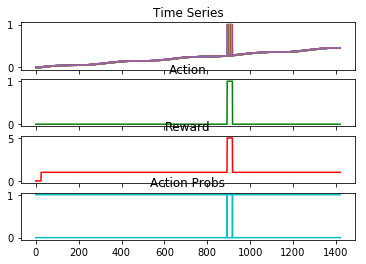

Episode @200000/500000 with loss: 1.15405321121
Get data time: 3.09944152832e-05
Update time: 0.0053379535675
Episode 1/1


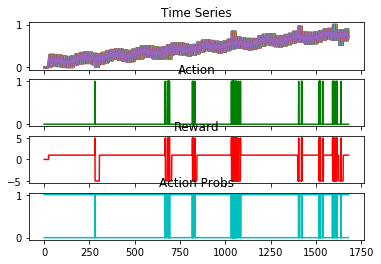

Episode @300000/500000 with loss: 0.093891531229
Get data time: 2.00271606445e-05
Update time: 0.00548195838928
Episode 1/1


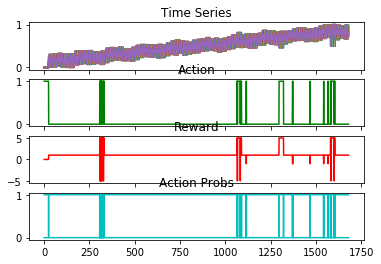

Episode @400000/500000 with loss: 1.42221975327
Get data time: 4.00543212891e-05
Update time: 0.00818204879761
Episode 1/1


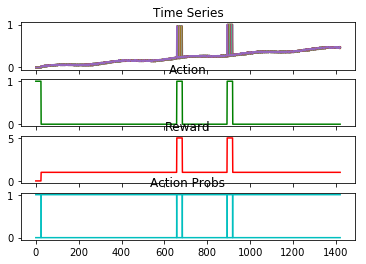

Episode @500000/500000 with loss: 1.91882789135
Get data time: 8.6784362793e-05
Update time: 0.00925397872925
Episode 1/1


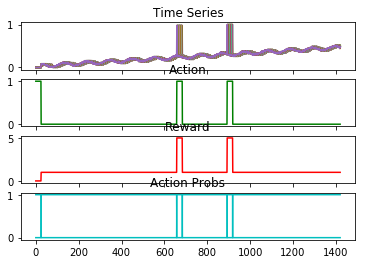

slide windows size: 25
neural network size: 100


In [14]:
tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step", trainable=False)

estimator = Q_Estimator_2Outputs(scope='estimator')

sess = tf.Session()
sess.run(tf.global_variables_initializer())

with sess.as_default():
    episodes = 500000
    elapsed_time_get_data = 0
    elapsed_time_update = 0
    
    for i in range(episodes):
        str_time = time.time()
        states, actions, rewards = get_data_steps(env)
        mid_time = time.time()
        loss = estimator.update(states, actions, rewards)
        end_time = time.time()
        
        elapsed_time_get_data = mid_time - str_time
        elapsed_time_update = end_time - mid_time
        
        if i%100000 == 99999:
            print("Episode @{}/{} with loss: {}".format(i+1,episodes,loss))
            print("Get data time: {}".format(elapsed_time_get_data))
            print("Update time: {}".format(elapsed_time_update))

            # q_estimator_plot(estimator)
            q_validator(env, estimator, 1)
            
    print("slide windows size: {}".format(SLIDE_WINDOW_SIZE))
    print("neural network size: {}".format(NEURAL_NETWORK_SIZE))

Episode @1000000/5000000 with loss: 1.24157583714
Get data time: 2.121925354e-05
Update time: 0.00402498245239
Episode 1/1


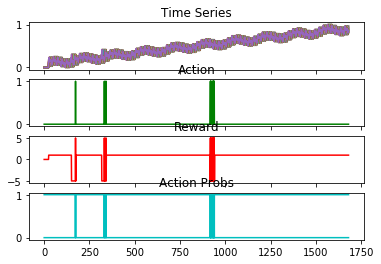

Episode @2000000/5000000 with loss: 0.296618908644
Get data time: 2.40802764893e-05
Update time: 0.00432085990906
Episode 1/1


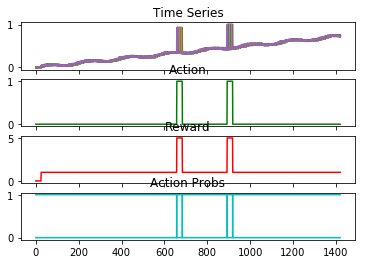

Episode @3000000/5000000 with loss: 4.35537528992
Get data time: 2.28881835938e-05
Update time: 0.00515198707581
Episode 1/1


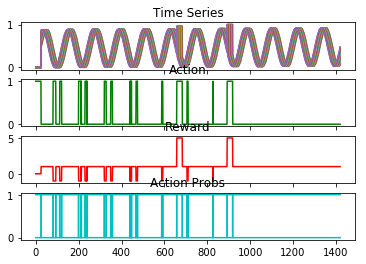

Episode @4000000/5000000 with loss: 0.257452368736
Get data time: 2.00271606445e-05
Update time: 0.00727295875549
Episode 1/1


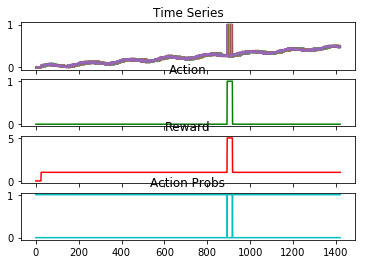

Episode @5000000/5000000 with loss: 3.32229757309
Get data time: 2.31266021729e-05
Update time: 0.0051109790802
Episode 1/1


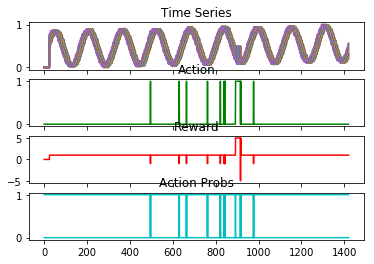

slide windows size: 25
neural network size: 100


In [18]:
with sess.as_default():
    episodes = 5000000
    elapsed_time_get_data = 0
    elapsed_time_update = 0
    
    for i in range(episodes):
        str_time = time.time()
        states, actions, rewards = get_data_steps(env)
        mid_time = time.time()
        loss = estimator.update(states, actions, rewards)
        end_time = time.time()
        
        elapsed_time_get_data = mid_time - str_time
        elapsed_time_update = end_time - mid_time
        
        if i%1000000 == 999999:
            print("Episode @{}/{} with loss: {}".format(i+1,episodes,loss))
            print("Get data time: {}".format(elapsed_time_get_data))
            print("Update time: {}".format(elapsed_time_update))

            # q_estimator_plot(estimator)
            q_validator(env, estimator, 1)
            
    print("slide windows size: {}".format(SLIDE_WINDOW_SIZE))
    print("neural network size: {}".format(NEURAL_NETWORK_SIZE))

Episode 1/10


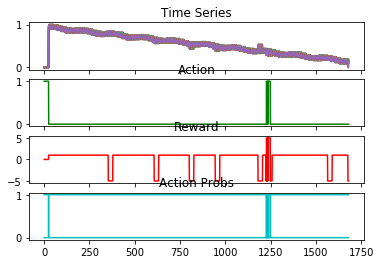

Episode 2/10


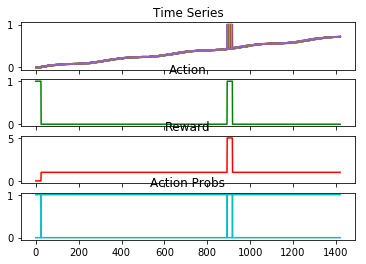

Episode 3/10


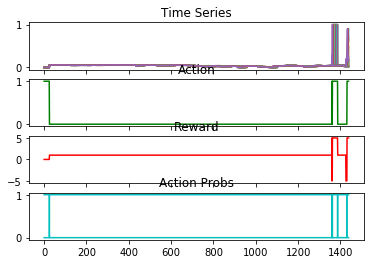

Episode 4/10


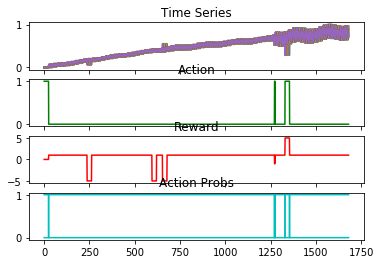

Episode 5/10


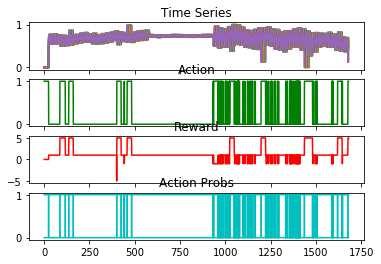

Episode 6/10


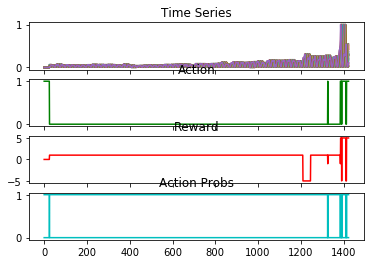

Episode 7/10


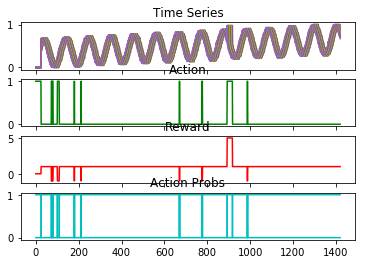

Episode 8/10


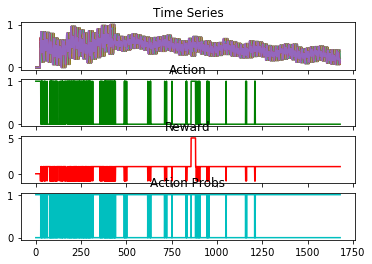

Episode 9/10


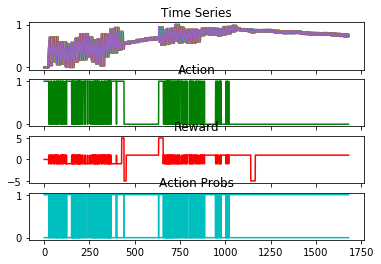

Episode 10/10


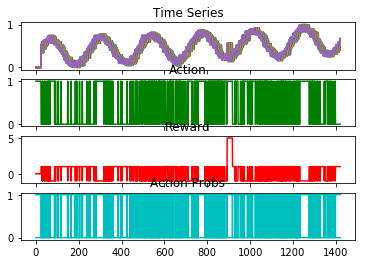

In [15]:
with sess.as_default():
    q_validator(env, estimator, 10)